# Setup


**Imports**


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

rng = np.random.default_rng()


**Utility functions**


In [2]:
phi = (1 + 5**0.5) / 2  # golden ratio ≈ 1.618


def fig_ax(figsize=(phi * 5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis="x", tight=True)
    return fig, ax

# Spectral feature


## Question 6


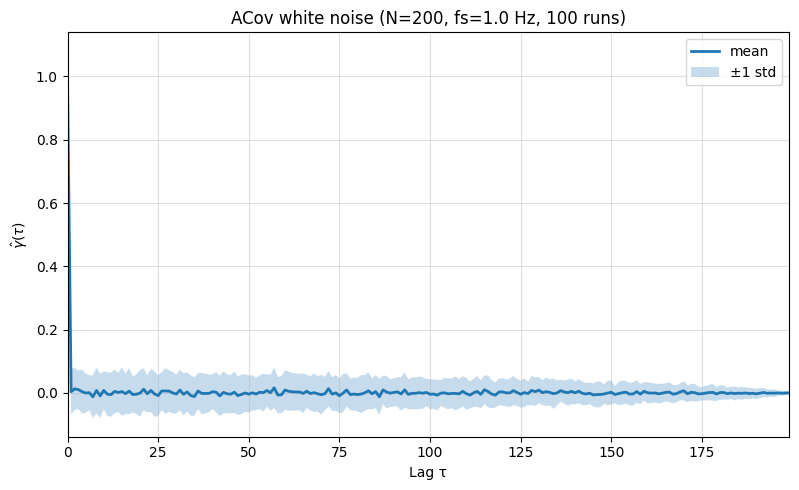

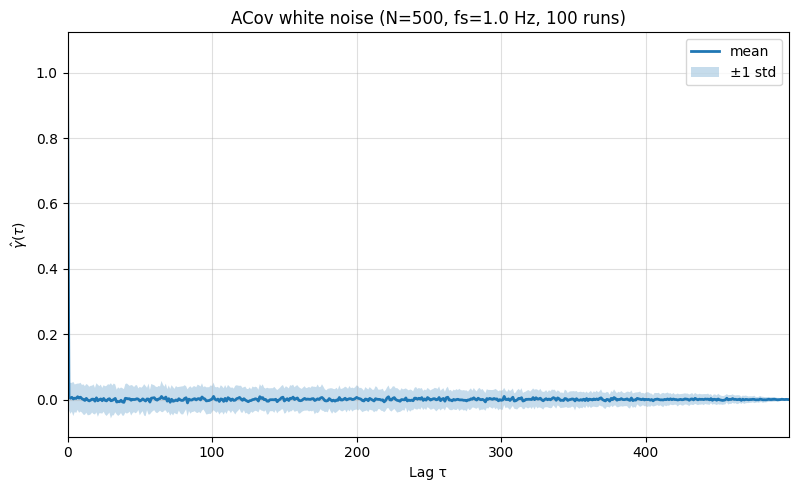

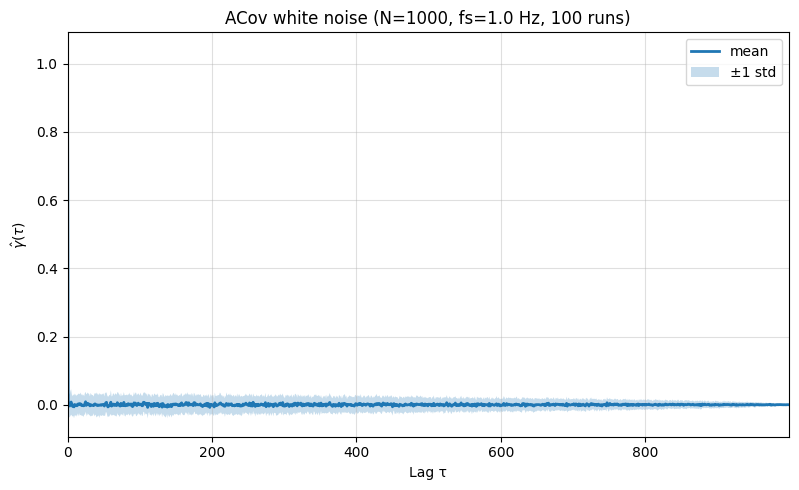

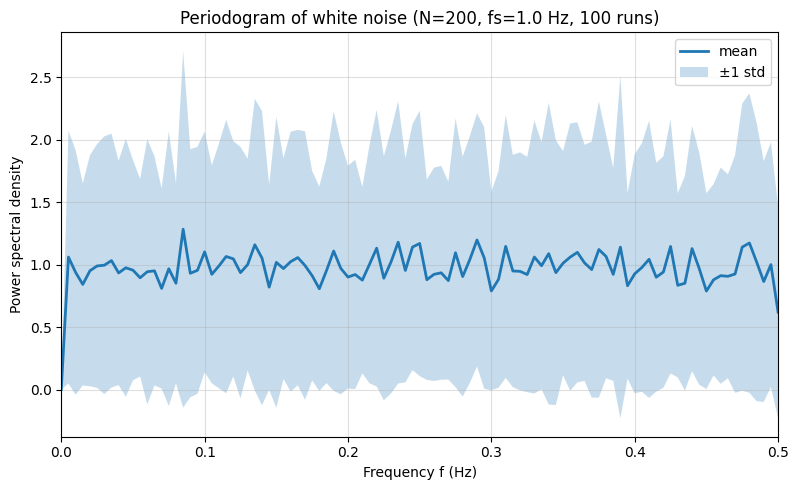

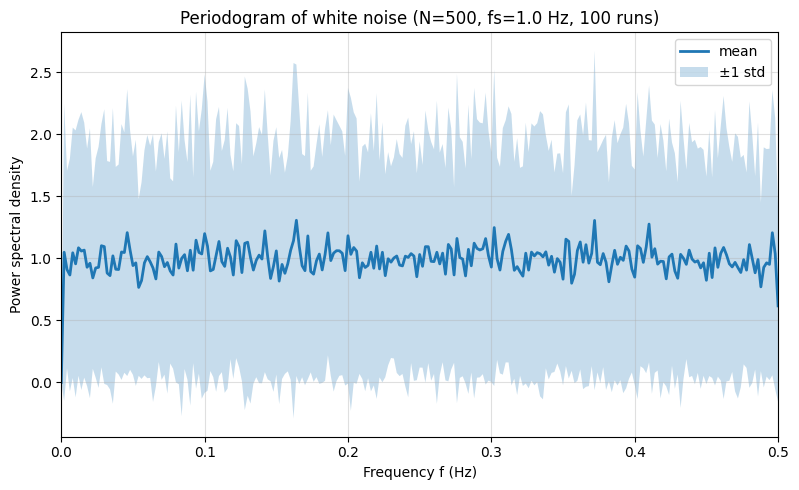

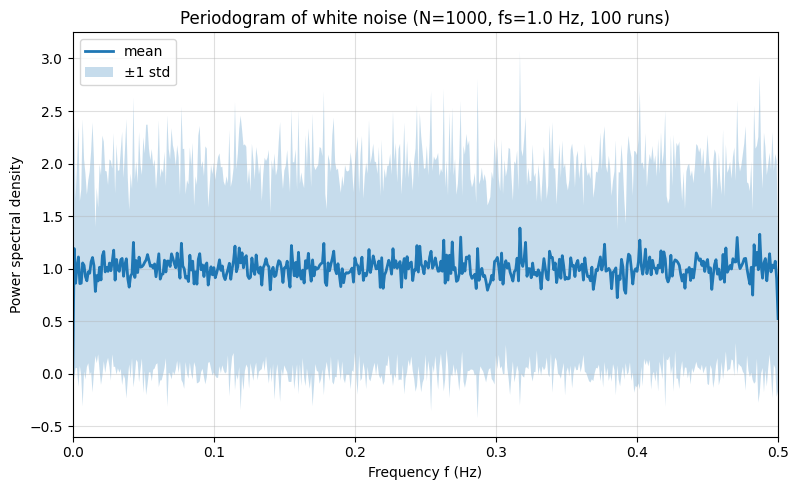

In [3]:
from statsmodels.tsa.stattools import acovf
from scipy.signal import periodogram


def sim_plot_acov_periodogram():
    # simulation parameters
    Ns = [200, 500, 1000]
    N_sim = 100
    fs = 1.0

    for N in Ns:
        # define max lag
        max_lag = N - 1
        acovs = np.zeros((N_sim, max_lag + 1))
        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            # compute biased estimate because less variance
            ac = acovf(x, demean=False, fft=True, adjusted=False)
            acovs[s] = ac[: max_lag + 1]

        mu, std = acovs.mean(0), acovs.std(0)
        lags = np.arange(max_lag + 1)

        fig, ax = fig_ax()
        ax.plot(lags, mu, lw=2, label="mean")
        ax.fill_between(lags, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"ACov white noise (N={N}, fs={fs} Hz, {N_sim} runs)")

        plt.xlabel("Lag τ")
        plt.ylabel(r"$\hat{\gamma}(\tau)$")
        plt.grid(alpha=0.4)
        plt.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(f"figures/acov_white_noise_N{N}_fs{fs}_sim{N_sim}.png")
        plt.show()

    for N in Ns:
        f, _ = periodogram(np.zeros(N), fs=fs)
        Pxx = np.zeros((N_sim, len(f)))

        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            f, Pxx[s] = periodogram(x, fs=fs, scaling="density", return_onesided=True)
            # rescale Pxx because periodogram returns one-sided PSD
            Pxx[s] /= 2

        mu, std = Pxx.mean(0), Pxx.std(0)

        fig, ax = fig_ax()
        ax.plot(f, mu, lw=2, label="mean")
        ax.fill_between(f, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"Periodogram of white noise (N={N}, fs={fs} Hz, {N_sim} runs)")
        plt.xlabel("Frequency f (Hz)")
        plt.ylabel("Power spectral density")
        plt.grid(alpha=0.4)
        plt.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(f"figures/periodogram_white_noise_N{N}_fs{fs}_sim{N_sim}.png")
        plt.show()


sim_plot_acov_periodogram()

## Question 9


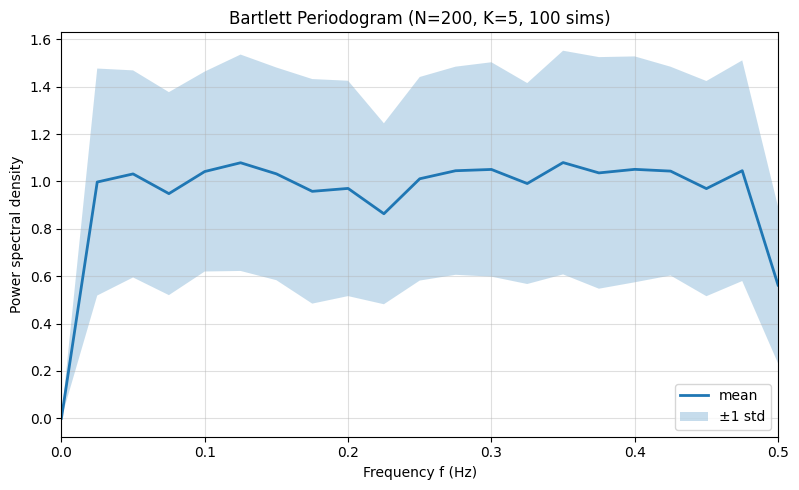

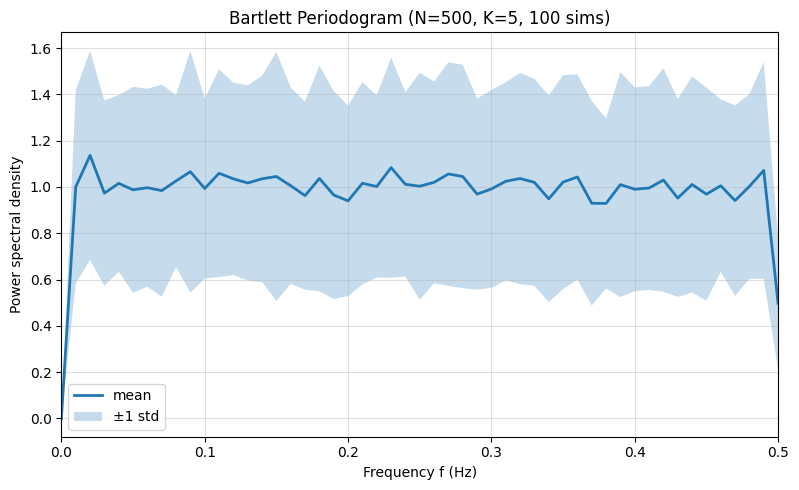

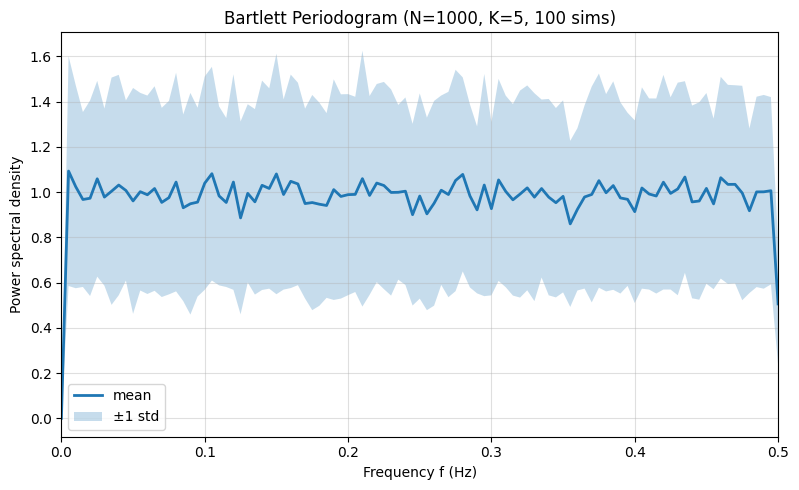

In [4]:
def sim_plot_periodogram_bartlett():
    Ns = [200, 500, 1000]
    N_sim = 100
    fs = 1.0
    K = 5

    for N in Ns:
        N_seg = N // K
        f, _ = periodogram(np.zeros(N_seg), fs=fs)  # correct frequency grid
        Pxx = np.zeros((N_sim, len(f)))

        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            x_segments = np.array_split(x, K)
            Pxx_segments = []
            for segment in x_segments:
                f, Pxx_seg = periodogram(
                    segment, fs=fs, scaling="density", return_onesided=True
                )
                Pxx_seg /= 2  # rescale for one-sided PSD
                Pxx_segments.append(Pxx_seg)
            Pxx[s] = np.mean(Pxx_segments, axis=0)

        mu, std = Pxx.mean(0), Pxx.std(0)

        fig, ax = fig_ax()
        ax.plot(f, mu, lw=2, label="mean")
        ax.fill_between(f, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"Bartlett Periodogram (N={N}, K={K}, {N_sim} sims)")
        ax.set_xlabel("Frequency f (Hz)")
        ax.set_ylabel("Power spectral density")
        ax.grid(alpha=0.4)
        ax.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(
            f"figures/bartlett_periodogram_white_noise_N{N}_K{K}_fs{fs}_sim{N_sim}.png"
        )
        plt.show()


sim_plot_periodogram_bartlett()

# Dynamic time warping (DTW)


## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:

- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.


**The task** is to classify footsteps in healthy/non-healthy.


The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.


In [5]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

In [6]:
len(X_train), len(X_test)

(168, 88)

## Question 10


In [7]:
#normalize the data
X_train_norm = [(x - np.mean(x)) / np.std(x) for x in X_train]
X_test_norm = [(x - np.mean(x)) / np.std(x) for x in X_test]

In [8]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [62]:
from matplotlib.lines import Line2D
def plot_data(X,y,title="Data"):
    fig, ax = fig_ax()
    for i in range(len(X)):
        if y[i] == 1:
            ax.plot(X[i], color='red', alpha=0.3)
        else:
            ax.plot(X[i], color='blue', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    # force add legend red and blue
    ax.grid(alpha=0.4)
    red_patch = Line2D([0], [0], color='red', lw=2, label='Pathological')
    blue_patch = Line2D([0], [0], color='blue', lw=2, label='Healthy')
    ax.legend(handles=[red_patch, blue_patch])
    plt.show()

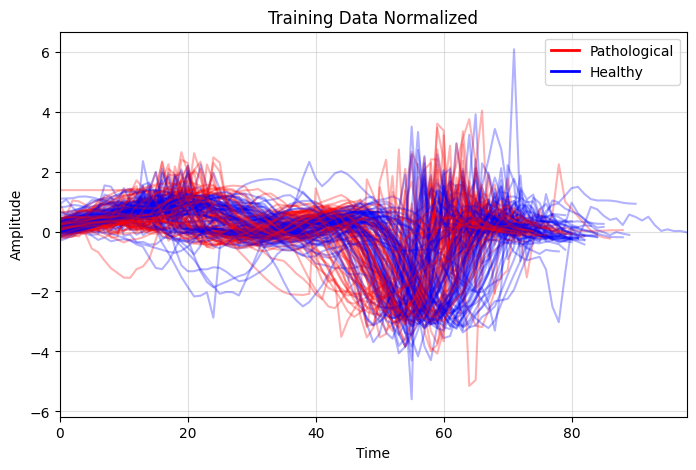

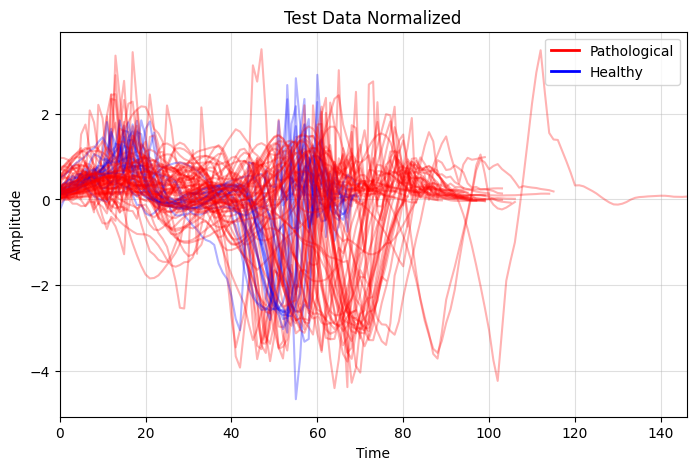

In [ ]:
plot_data(X_train_norm, y_train, title="Training Data Normalized")
plot_data(X_test_norm, y_test, title="Test Data Normalized")

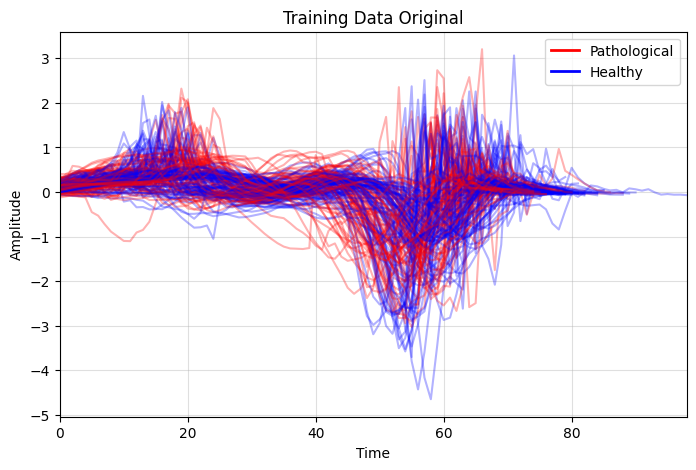

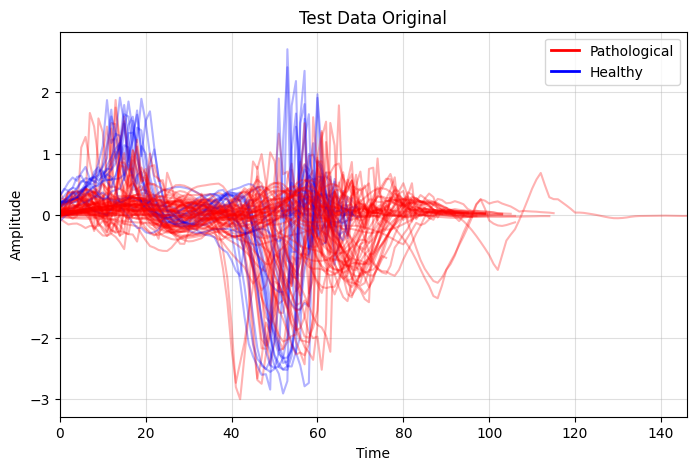

In [ ]:
plot_data(X_train, y_train, title="Training Data Original")
plot_data(X_test, y_test, title="Test Data Original")


In [69]:
unique_test, counts_test = np.unique(y_test, return_counts=True)
unique_train, counts_train = np.unique(y_train, return_counts=True)

#compute ratio of healthy to pathological in train and test
ratio_train = counts_train[1] / counts_train[0]
ratio_test = counts_test[1] / counts_test[0]
print(f"Train ratio of pathological to healthy: {ratio_train}, Test ratio of pathological to healthy: {ratio_test}")


Train ratio of pathological to healthy: 0.9090909090909091, Test ratio of pathological to healthy: 4.866666666666666


In [11]:
import numpy as np
from dtw import dtw
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from tqdm import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [12]:
#define parameters for model selection

k_values2test = [k for k in range(1,21)]  # test k from 1 to 20

n_folds = 5  # number of folds for cross-validation

results = defaultdict(list)  # to store f1-scores for each k 

#def dtw distance function
def dtw_dist(x, y):
    return dtw(x, y, keep_internals=False).distance

In [13]:
dist_matrix_train = np.zeros((len(X_train_norm), len(X_train_norm)))
for i in tqdm(range(len(X_train_norm))):
    for j in range(i + 1, len(X_train_norm)):
        dist = dtw_dist(X_train[i], X_train[j])
        dist_matrix_train[i, j] = dist
        dist_matrix_train[j, i] = dist


100%|██████████| 168/168 [00:10<00:00, 15.94it/s]


In [14]:
# We train the model for different number of neighbors and store the f1 score
avg_f1_scores = []
for k in tqdm(range(1, len(y_train)//2)):
    knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
    avg_f1_scores.append(cross_val_score(knn, dist_matrix_train, np.array(y_train), cv=5, scoring='f1').mean())

100%|██████████| 83/83 [00:02<00:00, 28.10it/s]


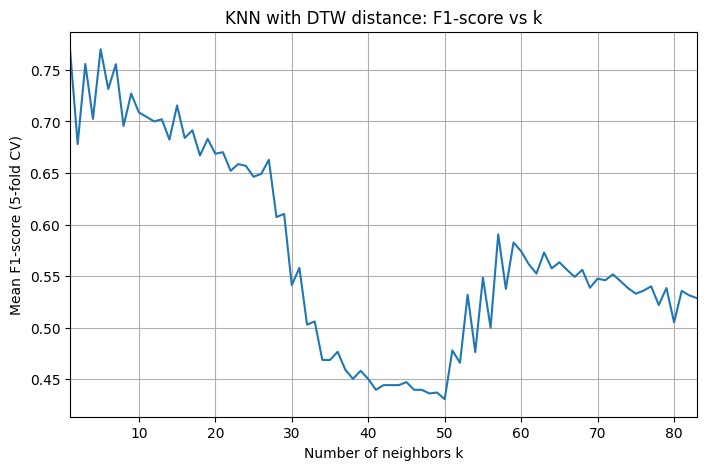

In [71]:
fig, ax = fig_ax()
ax.plot(range(1, len(y_train)//2), avg_f1_scores)
ax.set_xlabel("Number of neighbors k")
ax.set_ylabel("Mean F1-score (5-fold CV)")
ax.set_title("KNN with DTW distance: F1-score vs k")
ax.grid()
plt.show()

In [72]:
max(avg_f1_scores),np.argmax(avg_f1_scores)+1  # +1 because index starts at 0

(np.float64(0.76999333999334), np.int64(5))

In [18]:
# # manuel cross-validation
# for k in k_values2test:
#     print(f"Evaluating k={k}...")
#     kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
#     for fold_idx, (train_index, test_index) in tqdm(enumerate(kf.split(X_train_norm))):
#         # Create train/validation sets for this fold
#         X_train_k = [X_train_norm[i] for i in train_index]
#         y_train_k = y_train[train_index]
#         X_val_k = [X_train_norm[i] for i in test_index]
#         y_val_k = y_train[test_index]

#         # Initialize k-NN classifier with DTW distance
#         n_train = len(X_train_k)
#         dist_matrix_train = np.zeros((n_train, n_train))
#         for i in range(n_train):
#             for j in range(i + 1, n_train):
#                 dist = dtw_dist(X_train_k[i], X_train_k[j])
#                 dist_matrix_train[i, j] = dist
#                 dist_matrix_train[j, i] = dist # Matrix is symmetric
        
#         # B) dist_matrix_test (shape: n_test_samples x n_train_samples)
#         n_test = len(X_val_k)
#         dist_matrix_test = np.zeros((n_test, n_train))
#         for i in range(n_test):
#             for j in range(n_train):
#                 dist = dtw_dist(X_val_k[i], X_train_k[j])
#                 dist_matrix_test[i, j] = dist


#         # 3. Fit the k-NN classifier
#         # We tell it to use our precomputed matrix
#         clf = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
#         # Fit on the TRAIN-vs-TRAIN matrix
#         clf.fit(dist_matrix_train, y_train_k)

#         # 4. Predict
#         # Predict using the TEST-vs-TRAIN matrix
#         y_pred = clf.predict(dist_matrix_test)

#         # 5. Score and save the result
#         # Use 'weighted' F1 for imbalanced classes, or 'macro'
#         f_score = f1_score(y_val_k, y_pred, average='weighted')
#         results[k].append(f_score)
#     print(f"F1-score for k={k}: {np.mean(results[k]):.4f}")
#     print(f"Done k={k}.")

# print("Cross-validation done.")

    

In [19]:
# avg_f1_scores = {k: np.mean(v) for k, v in results.items()}
# avg_f1_scores

In [20]:
# Calculate the average F-score for each k
# avg_f_scores = {k: np.mean(scores) for k, scores in results.items()}

# Find the optimal k
optimal_k = np.argmax(avg_f1_scores)+1
optimal_f_score = np.max(avg_f1_scores)

# --- FINAL REPORT ---
print("\n" + "="*30)
print("     Optimal k-NN Results")
print("="*30)
print(f"Optimal number of neighbors (k): {optimal_k}")
print(f"Associated F-score (average): {optimal_f_score:.4f}")

# --- COMMENT ---
print("\nComment:")
print(f"The optimal 'k' was found to be {optimal_k}. This suggests that the classifier makes its most reliable")
print(f"decisions by looking at a consensus of {optimal_k} 'neighboring' steps from the training data.")
print(f"An F-score of {optimal_f_score:.4f} indicates the model's performance level (e.g., >0.9 is excellent, >0.7 is good).")


     Optimal k-NN Results
Optimal number of neighbors (k): 5
Associated F-score (average): 0.7700

Comment:
The optimal 'k' was found to be 5. This suggests that the classifier makes its most reliable
decisions by looking at a consensus of 5 'neighboring' steps from the training data.
An F-score of 0.7700 indicates the model's performance level (e.g., >0.9 is excellent, >0.7 is good).


In [84]:
#train final model with optimal k on full training set and evaluate on test set

# 2. Compute distance matrix for test set vs training set
n_test_full = len(X_test_norm)
n_train_full = len(X_train_norm)
dist_matrix_test = np.zeros((n_test_full, n_train_full))
for i in tqdm(range(n_test_full)):
    for j in range(n_train_full):
        dist = dtw_dist(X_test_norm[i], X_train_norm[j])
        dist_matrix_test[i, j] = dist


100%|██████████| 88/88 [00:11<00:00,  7.65it/s]


In [85]:
# 3. Fit the k-NN classifier with optimal k
clf_final = KNeighborsClassifier(n_neighbors=optimal_k, metric='precomputed')
clf_final.fit(dist_matrix_train, y_train)
# 4. Predict on the test set
y_test_pred = clf_final.predict(dist_matrix_test)
# 5. Score the final model
final_f_score = f1_score(y_test, y_test_pred)


In [86]:
#print final results
print("\n" + "="*30)
print("       Final Test Results")
print("="*30)
print(f"F-score on the test set: {final_f_score:.4f}")


       Final Test Results
F-score on the test set: 0.4602


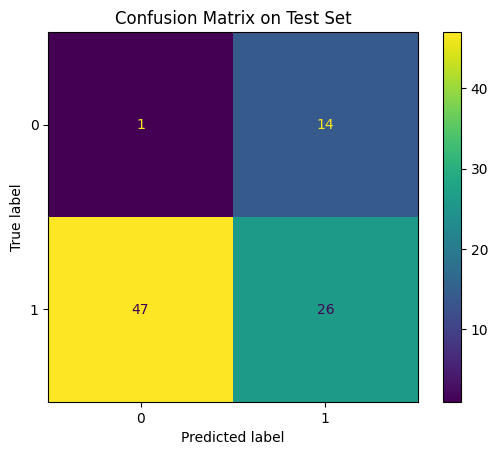

In [87]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred, labels=clf_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_final.classes_)
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()


## Question 11


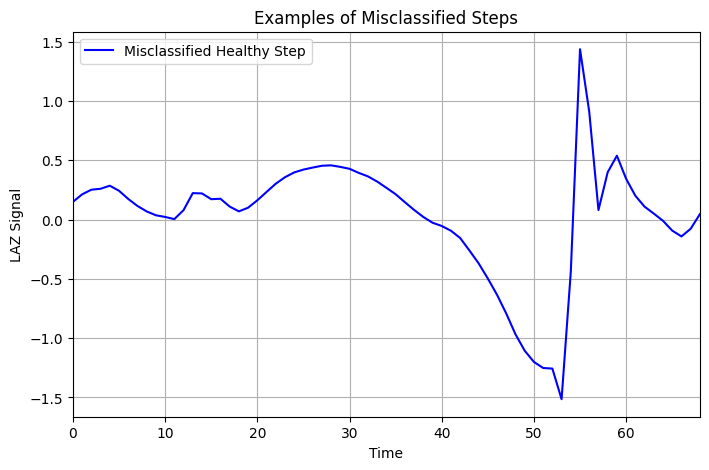

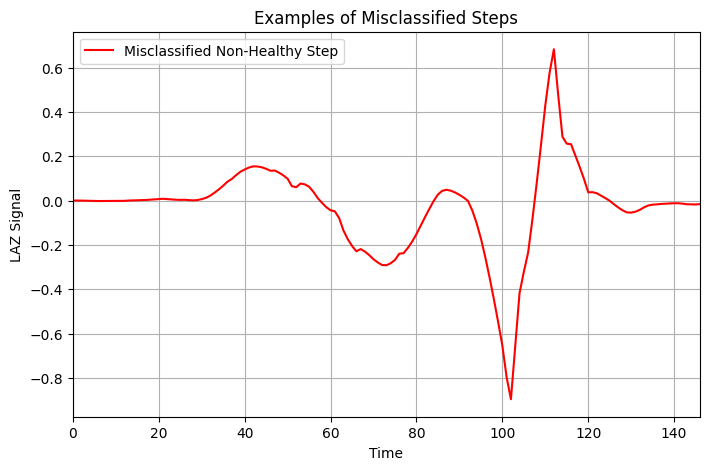

In [88]:
# Display on Figure 3 a badly classified step from each class (healthy/non-healthy).

misclassified_indexes = np.where(y_test != y_test_pred)[0]
misclassified_healthy = None
misclassified_non_healthy = None
for idx in misclassified_indexes:
    if y_test[idx] == 0 and misclassified_healthy is None:
        misclassified_healthy = X_test[idx]
    elif y_test[idx] == 1 and misclassified_non_healthy is None:
        misclassified_non_healthy = X_test[idx]
    if misclassified_healthy is not None and misclassified_non_healthy is not None:
        break


fig, ax = fig_ax()
ax.plot(misclassified_healthy, label='Misclassified Healthy Step', color='blue')
ax.set_title('Examples of Misclassified Steps')
ax.set_xlabel('Time')
ax.set_ylabel('LAZ Signal')
ax.legend()
ax.grid()
plt.show()


fig, ax = fig_ax()
ax.plot(misclassified_non_healthy, label='Misclassified Non-Healthy Step', color='red')
ax.set_title('Examples of Misclassified Steps')
ax.set_xlabel('Time')
ax.set_ylabel('LAZ Signal')
ax.legend()
ax.grid()
plt.show()
